In [1]:
# filename: minianalysis__cognate_variables.py
# 
# description: Runs models as specified originally and again after replacing a central variable by a cognate variable.
# It compares regressions on what was then the new data vs same regressions on future waves
# 
# inputs:
# 
# outputs:
# 
# @author: Misha Teplitskiy, mishateplitskiy@gmail.com
# 
# 2017-07-13 debugging z
#   1. trying getting rid of 'ddof=1' for IVs and only kept it for DV, to see if that would make a difference
#
#
#

from __future__ import division


import pandas as pd
pd.set_option('use_inf_as_na', True) 
import pickle

import sys
sys.path.append('../')    
import GSSUtility as GU # note, this imports the .PY file, so if I made changes to the IPYNB file, I first need to convert it 
                        # to PY for changes to actually take effect
                        # conversion can be done with 'jupyter nbconvert --to script GSSUtility.py'
import numpy as np
from numpy import nan
import statsmodels.formula.api as smf 
import random
from scipy.stats import pearsonr, ttest_ind, ttest_rel
import time
from collections import Counter, defaultdict

In [2]:
%rm ../GSSUtility_old.pyc

In [3]:
%rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
reload(GU)

<module 'GSSUtility' from '../GSSUtility.py'>

In [7]:
if __name__ == "__main__":    

    try:
        %rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
        reload(GU)
    except:
        pass
    
    pathToData = '../../Data/'
    dataCont = GU.dataContainer(pathToData)
    
#     tempCognateOutput = open(pathToData + 'tempCognateOutput.txt', 'w')
    
    # contains for storing (variable, cognate) tuples in order to see what substitutions
    #i'm most commonly making
    variableCognateTuples = []
    
    # define the storage containers for outputs
    group1 = 'original model'
    group2 = 'cognate model'   
    groups = [group1, group2]
    outcomes = ['propSig_ControlVars', 'paramSizesNormed_ControlVars', 'Rs', 'adjRs', 
                'propSig_CentralVars', 'paramSizesNormed_CentralVars']
    output = defaultdict(dict)
    output['metadata'] = {'article_id':[]}
    for outcome in outcomes:
        for group in groups:
            output[outcome][group] = []
    
    articlesToUse = GU.filterArticles(dataCont.articleClasses, GSSYearsUsed=True, GSSYearsPossible=False, \
                                      centralIVs=True, 
                                      linearModels=False) 
    
    for article in articlesToUse:
#     for article in random.sample(articlesToUse, 50):
    
#     for article in [a for a in articlesToUse if a.articleID == 1343]:
    
        print '\n\n\==============================\nProcessing article:', article.articleID

        # let's see if this article is suitable for cognates analysis:
        originalLHS = article.IVs + article.controls
        identifyCognatesReturns = GU.identifyCognates(dataCont, originalLHS, article.centralIVs, article.GSSYearsUsed, corrThreshold=0.6 )        
        if not identifyCognatesReturns: 
            print 'No suitable cognates. Skipping.'            
            continue        
        else: 
            cIV, cognate, GSSYearsWithCognate = identifyCognatesReturns
#             cognate = str(cognate)
#             print 'just identified cIV:', cIV, 'and cognate', cognate
#             print article.centralIVs
            
        # if we got this far, then this article does have suitable cognates, so let's estimate models       
        # Now let's estimate the models
        print 'overall cIV is', cIV, 'and cognate is', cognate
        for DV in article.DVs:            
            
            if cognate == DV: continue # sometimes the cognate suggested by GU.identifyCognates is the DV

            cognateLHS = originalLHS[:] # the "[:]" makes a deep copy ?
            cognateLHS.remove(cIV)
            cognateLHS.append(cognate) # need to put it in list otherwise it treats each letter as an element
#                 print 'Substituting', cIV, 'with cognate', cognate     
            # make sure cIV is last in the list of variables
            originalLHS.remove(cIV)
            originalLHS.append(cIV) 

            # CHOOSE YEARS
#             for year in GSSYearsWithCognate:  # This version calculates COGNATE - ORIGINAL difference for each year
                                                # of GSSYearsUsed for each the chosen COGNATE appears
            year = max(GSSYearsWithCognate) # let's instead run on last year only (?)


            # RUN ORIGINAL (GROUP 1) MODEL, and COGNATE (GROUP 2) MODEL
            result_orig = GU.runModel(dataCont, year, DV, originalLHS)                     
            if not result_orig: continue # results will be None if the formula cant be estimated
            result_cog = GU.runModel(dataCont, year, DV, cognateLHS)          
            if not result_cog: continue # results will be None if the formula cant be estimated
            results = [result_orig, result_cog]

            # BUILD LIST OF CENTRAL VARIABLES
            # first with the original model
            centralVarsOrig, centralVarsCognate = [], []            
        
            for civ in article.centralIVs:
                for param in results[0].params.index:
                    if civ in param: centralVarsOrig.append(param)
                        
            # now the COGNATE model
            cIVs_cognate = article.centralIVs[:]
            try:
                cIVs_cognate.remove(cIV)
                cIVs_cognate.append(cognate)
#                     print 'building cognate model'
#                     print 'removing civ', cIV, 'and adding cognate', cognate
            except:
                print 'building model didnt work. tried to remove', cIV, 'and append', cognate, 'from\n'
                print cIVs
                break

            for civ in cIVs_cognate:
                for param in results[1].params.index:
                    if civ in param: centralVarsCognate.append(param)

            centralVars = [centralVarsOrig, centralVarsCognate]

            # identify variable names (exact strings) of CONTROL variables
            controlVars = set(results[0].params.index) - set(centralVarsOrig + ['Intercept'])                        

            # Checks on which results to record                
            if len(result_cog.params) != len(result_orig.params):
                print 'The number of variables in original model is different from the number in cognate model. Skipping.'                    
                continue

            for i in range(2):                 
                # OVERALL MODEL FIT
                output['Rs'][groups[i]].append(results[i].rsquared) 
                output['adjRs'][groups[i]].append(results[i].rsquared_adj) 

                # CONTROL variables
                if len(controlVars)>0:
                    output['propSig_ControlVars'][groups[i]].append(float(len([p for p in results[i].pvalues[controlVars] if p < 0.05])) \
                                                            /len(controlVars)) 
                    output['paramSizesNormed_ControlVars'][groups[i]].append(results[i].params[controlVars].abs().mean())
                else:
                    output['propSig_ControlVars'][groups[i]].append(np.nan)
                    output['paramSizesNormed_ControlVars'][groups[i]].append(np.nan)

                # CENTRAL variables
                if len(centralVars[0])>0: # need to look into first element because even empty centralVars is 2-elements: [[], []]
                    output['propSig_CentralVars'][groups[i]].append(float(len([p for p in results[i].pvalues[centralVars[i]] if p < 0.05])) \
                                                            /len(centralVars[i])) 
                    output['paramSizesNormed_CentralVars'][groups[i]].append(results[i].params[centralVars[i]].abs().mean())
                else:
                    output['propSig_CentralVars'][groups[i]].append(nan) 
                    output['paramSizesNormed_CentralVars'][groups[i]].append(nan)                

            output['metadata']['article_id'].append(article.articleID)  
                
                
    print '\n\n============================================\nFINISHED RUNNING MODELS'

# I dump the file here, because this allows me to run this script as a standalone .py file in command line...
# it saves the output fine, and then crashes (intentionally) when it gets to the viz part further below
pickle.dump(output, open('output.pickle', 'w'))

Loading DataFrame df. This may take a few minutes.


TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType

# Break
This and the following cells are designed to do an intermediate output --> input step, so that I can run this script WITHOUT graphics (command line), and then just come to this notebook to VISUALIZE the results

## Load the results of the analysis (output.pickle) and store them in convenient form (df_output)

In [33]:
# load the output pickle after running models
output = pickle.load(open('output.pickle'))

group1 = 'original model'
group2 = 'cognate model'   
groups = [group1, group2]
outcomes = ['propSig_ControlVars', 'paramSizesNormed_ControlVars', 'Rs', 'adjRs', 
            'propSig_CentralVars', 'paramSizesNormed_CentralVars']

df_output = pd.DataFrame(index=np.arange(len(output['Rs'][group1])), 
                         columns=pd.MultiIndex.from_product([outcomes, groups]))
df_output.columns.names = ['outcome','group']
for outcome in outcomes:
    for gp in groups:
        df_output[outcome, gp] = output[outcome][gp]
df_output.index = output['metadata']['article_id']
df_output['article_id'] = output['metadata']['article_id']

print 'Using %d models from %d articles' % (len(df_output), len(df_output.index.unique()))

Using 1469 models from 215 articles


In [28]:
# output article IDs for use in replication project. 2016-06-07
'''
fout = open('minianalysis_cognate_variables_list_of_articles_used.csv',  'wb')
fout.write(','.join(map(str, sorted(df_output.index.unique())))) # unique article IDs used, separated by commas
fout.close()
'''

"\nfout = open('minianalysis_cognate_variables_list_of_articles_used.csv',  'wb')\nfout.write(','.join(map(str, sorted(df_output.index.unique())))) # unique article IDs used, separated by commas\nfout.close()\n"

## The part below is where running command-line script should crash

In [23]:
# %matplotlib inline
# # #Plot outcomes - (new) distribution of differences approach

# outcomeMap = {'propSig':"% of Stat. Sign. Coeff's", 
#               'paramSizesNormed':"Standard. Size of Coeff's",
#               'Rs':'R-squared', 
#               'adjRs':'Adj. R-squared',
#               'pvalues':"Avg. P-Value of Coeff's",
#               'propSig_CentralVars':"Central IVs: % of Stat. Sign. Coeff's",
#               'paramSizesNormed_CentralVars':"Central IVs: Standard. Size of Coeff's", 
#               'pvalues_CentralVars':"Central IVs: Avg. P-Value of Coeff's"}

# outcomeXlimits = {'propSig':(-.2,.2), 
#               'paramSizesNormed':(-.04,.04),
#               'Rs':(-.04, .06), 
#               'adjRs':(-.04, .06),
#               'pvalues':(-.2, .2),
#               'propSig_CentralVars':(-.2, .4),
#               'paramSizesNormed_CentralVars':(-.1,.1), 
#               'pvalues_CentralVars':(-.2, .2)}

# outcomeYlimits = {'propSig':80, 
#               'paramSizesNormed':100,
#               'Rs':120, 
#               'adjRs':120,
#               'pvalues':17,
#               'propSig_CentralVars':8.5,
#               'paramSizesNormed_CentralVars':40, 
#               'pvalues_CentralVars':11.5}

# for outcome in outcomes:
#     plt.figure(figsize=(3,3))
#     if outcome=='article_id': continue
#     if outcome=='numTotal':continue

#     plt.xticks(fontsize=12)
#     plt.locator_params(nbins=7)
#     plt.yticks(fontsize=15)
#     plt.ylabel('Density', fontsize=17)
#     plt.title(outcomeMap[outcome], fontsize=20)
#     plt.xlim(outcomeXlimits[outcome])    
    
#     sb.kdeplot((df_output[group1, outcome] - df_output[group2, outcome]), 
#                 color='black', legend=False, shade=True)
#     plt.plot([0,0], [0,outcomeYlimits[outcome]], '--', color='black', linewidth=2)
    
# #     plt.savefig('images/cognate-differences--' + outcome + '.png', bbox_inches='tight')
# #     break

# # <markdowncell>

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb
custom_style = {'axes.facecolor': 'white',
                'grid.color': '0.15',
                'grid.linestyle':'-.'}
sb.set_style("darkgrid", rc=custom_style)

In [30]:
df_output.groupby('article_id').mean()['propSig_CentralVars'][group1].mean()

0.39977016872268883

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8]),
 <a list of 10 Text yticklabel objects>)

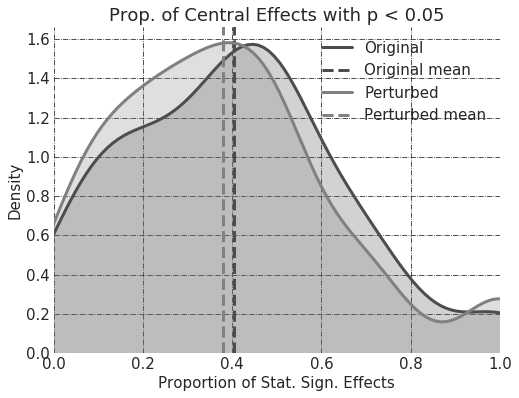

In [34]:
# ONE EXAMPLE OF DIFFERENCES IN DISTRIBUTION: PROP OF STAT. SIGN. EFFECTS FOR CENTRAL VARS
plt.figure(figsize=(8,6))
sb.kdeplot(df_output.groupby('article_id').mean()['propSig_CentralVars'][group1], 
           color='0.3', shade=True, label='Original', linewidth=3)
plt.plot([df_output.groupby('article_id').mean()['propSig_CentralVars'][group1].mean()]*2, [0,2], 
         '--', c='0.3', linewidth=3, label='Original mean')
sb.kdeplot(df_output.groupby('article_id').mean()['propSig_CentralVars'][group2], 
           color='0.5', shade=True, label='Perturbed', linewidth=3)
plt.plot([df_output.groupby('article_id').mean()['propSig_CentralVars'][group2].mean()]*2, [0,2], '--', c='0.5', linewidth=3, label='Perturbed mean')
plt.legend(loc='best', fontsize=15)
plt.title('Prop. of Central Effects with p < 0.05', fontsize=18)
plt.xlabel('Proportion of Stat. Sign. Effects', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xlim(0, 1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig('images/cognate-example-of-differences-in-distributions-prop-sign-of-central-effects.png', bbox_inches='tight', dpi=150)

In [34]:
# # #Plot outcomes - (old) bar chart approach
# %matplotlib inline

# plt.figure(figsize=(14,8))
# outcomesToUse = df_output[group1].columns
# indices = np.arange(len(outcomesToUse))
# width = 0.35
# error_config = {'ecolor': '0.3'}

# axes = plt.figure().add_subplot(111)
# rects1 = plt.bar(left=indices, width=width, height=df_output[group1].mean(), color='0.75', 
#              yerr=2*df_output[group1].std()/np.sqrt(len(df_output[group1])),
#              error_kw=error_config) #this is not very relevant because we're not comparing independent groups
# rects2 = plt.bar(left=indices+width, width=width, height=df_output[group2].mean(), color='0.5', 
#              yerr=2*df_output[group2].std()/np.sqrt(len(df_output[group2])),
#              error_kw=error_config)

# # title, legend, etc
# plt.title('Original vs. Cognate Models', fontsize=18)
# plt.legend((rects1[0], rects2[0]), ('Original models', 'Cognate models'), fontsize=15)
# # legend((rects1[0], rects2[0]), ('Original models', 'Cognate models'), fontsize=15)
# plt.xlim((-1*width, len(outcomesToUse)))

# # tick labels
# # a = outcomesToUse
# a = ['% of coeffs. stat. sign.', 'avg. coeff. size', 'R_sq.', 'adj. R_sq.', 'avg. p-value', \
#      '"central" vars: % of coeffs. stat. sign.', '"central" vars: avg. coeff. size', '"central" vars: avg. p-value']
# axes.set_xticks(indices+width)
# axes.set_xticklabels(a, rotation=90, fontsize=15)

# # label the bars with the difference between them
# diffs = (df_output[group1] - df_output[group2]).mean().values
# def autolabel(rects):
#     # attach some text labels
#     for i, rect in enumerate(rects):
#         height = rect.get_height()
#         if i!=7 and i!=4:
#             axes.text(rect.get_x()+width, 1.03*height, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
#         else: # this is for the p-value label, which has gone up
#             axes.text(rect.get_x()+width, 1.03*height+0.05, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
# autolabel(rects1)

# # plt.figure(figsize=(6,5))
# # (df_output[group1]['paramSizesNormed'] - df_output[group2]['paramSizesNormed']).plot(kind='kde')
# # plt.plot([0,0], [0,20], '--')
# # plt.title('Differences in Stand. Coeff. Size. between orig. and cognate')

# # # <codecell>

# # mn= np.mean((df_output[group1, 'Rs'] - df_output[group2, 'Rs']).values)
# # sd= np.std((df_output[group1, 'Rs'] - df_output[group2, 'Rs']).values)
# # print mn, sd, mn/(sd/np.sqrt(df_output.shape[0]))

# # <markdowncell>

In [35]:
# #temp fix to convert proportions into percentages
# for group in [group1, group2]:
#     for o in ['propSig', 'propSig_CentralVars']:
#         df_output[group, o] = df_output[group, o]/100

adjRs
-0.008065321576850274 Ttest_relResult(statistic=2.8288720813273462, pvalue=0.005115237617609277)
Rs
-0.003002532311317152 Ttest_relResult(statistic=2.191824882366803, pvalue=0.029470793824563562)
paramSizesNormed_CentralVars
0.0020460365756517647 Ttest_relResult(statistic=-0.9395229307947799, pvalue=0.34852156118473976)
propSig_CentralVars
-0.024066434865424948 Ttest_relResult(statistic=2.5767634977258433, pvalue=0.01064542553394616)
paramSizesNormed_ControlVars
0.009338907895667445 Ttest_relResult(statistic=-1.564114544229589, pvalue=0.12137984624243334)
propSig_ControlVars
-0.029116210508085213 Ttest_relResult(statistic=1.445073027998765, pvalue=0.15198899138616184)


Text(0.5,0,'Change (perturbed - original)')

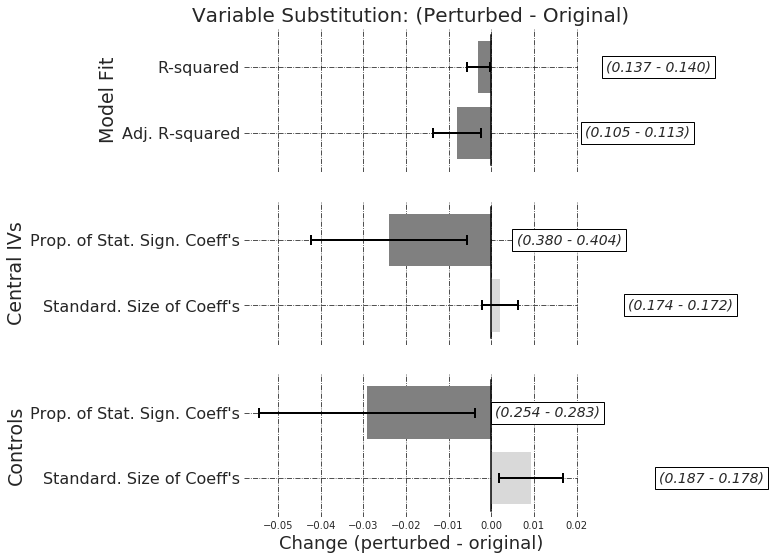

In [35]:
%matplotlib inline

# fig = plt.figure(figsize=(6,9))
# note, the order below is reversed for each two outcomes because that's how numbering works for plotting purposes
outcomesToUse = [u'adjRs',
                 u'Rs',
                 u'paramSizesNormed_CentralVars',                
                 u'propSig_CentralVars', 
                 u'paramSizesNormed_ControlVars',
                 u'propSig_ControlVars']

outcomeMap = {'propSig_ControlVars':"Prop. of Stat. Sign. Coeff's", 
              'paramSizesNormed_ControlVars':"Standard. Size of Coeff's",
              'Rs':'R-squared', 
              'adjRs':'Adj. R-squared',
#               'pvalues':"Avg. P-Value of Coeff's",
              'propSig_CentralVars':"Prop. of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Standard. Size of Coeff's"}

# indices = [1,2,4,5,7,8]
width = 0.5
error_config = dict(ecolor='0', lw=2, capsize=5, capthick=2)

# diffs = [100*(df_output[group2, outcome] - df_output[group1, outcome]).mean()/df_output[group1, outcome].mean() for outcome in outcomesToUse]
# diffs_strings = ['(%0.3f - %0.3f)' % (df_output[group1, outcome].mean(), df_output[group2, outcome].mean()) 
#                  for outcome in outcomesToUse]
# diffs = np.array(diffs)

# # naive SES
# # ses = [(df_output[group1, outcome] - df_output[group2, outcome]).std()/np.sqrt(len(df_output)) for outcome in outcomesToUse]

# # clustered SES
# clusteredSES = []
# article_ids = np.array(list(df_output.index)) 
# for outcome in outcomesToUse:
#     diff = 100*(df_output[outcome, group2] - df_output[outcome, group1])
#     mask = ~np.isnan(np.array(diff))
#     result_clustered = smf.ols(formula='y~x-1', \
#                      data=pd.DataFrame({'y':diff[mask], 'x':[1]*len(diff[mask])})).fit(missing='drop', \
#                                                                              cov_type='cluster', \
#                                                                     cov_kwds=dict(groups=article_ids[mask]))
#     clusteredSES.append(result_clustered.HC0_se[0])
# clusteredSES = np.array(clusteredSES)

# CONSERVATIVE TESTs
# these will be based only on n. of articles
conservativeSES = []
diffs = []
diffs_strings = []

for outcome in outcomesToUse:

#     df_output_copy['difference'] = 100*(df_output[outcome, group2] - df_output[outcome, group1])
#     mean_difference = df_output_copy.groupby('article_id').difference.mean()
#     se = np.std(mean_difference) / np.sqrt(len(mean_difference))

    print outcome
    group1outcome = df_output[outcome, group1].groupby(df_output.index).mean()
    group2outcome = df_output[outcome, group2].groupby(df_output.index).mean()
    diff = (group2outcome - group1outcome)
#     perc_changes = 100*(group2outcome - group1outcome) / group1outcome

    diffs.append(diff.mean())
    diffs_strings.append('(%0.3f - %0.3f)' % (group2outcome.mean(), group1outcome.mean()))
    
    se = diff.std() / np.sqrt(len(group1outcome))
    conservativeSES.append(se)
    
    # also do a t-test (related samples)
    mask = group1outcome.notnull() & group2outcome.notnull()
    print diff.mean(), ttest_rel(group1outcome[mask], group2outcome[mask])
    
diffs = np.array(diffs)
conservativeSES = np.array(conservativeSES)


colors = ['0.5' if el < 0 else '0.85' for el in diffs]

# plt.barh(indices, diffs, xerr=2*np.array(clusteredSES), align='center', color=colors, error_kw=error_config)
# axes.set_yticks(indices)
# axes.set_yticklabels([outcomeMap[o] for o in outcomesToUse], fontsize=17)

f, axarr = plt.subplots(3, sharex=True, figsize=(6,9))
                        
for i in range(3):
    # bars
#     xerr = 2*clusteredSES[i*2:i*2+2] / diffs[i*2:i*2+2] # i am dividing here because we want the SEs to be on the percent-change scale, not raw scale
    xerr = 1.96*conservativeSES[i*2:i*2+2]
    boxes = axarr[i].barh([0,1], diffs[i*2:i*2+2], xerr=xerr, 
             align='center', color=colors[i*2:i*2+2], error_kw=error_config)
   
    # annotate boxes: raw means
    box0_xcoord = boxes[0].get_bbox().get_points()[1,0] + .01 # the indices here mean get the x-coord of 2nd box corner
    box1_xcoord = boxes[1].get_bbox().get_points()[1,0] + .01

    axarr[i].text(box0_xcoord + 0.02, 0, diffs_strings[i*2], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')
    axarr[i].text(box1_xcoord + 0.02, 1, diffs_strings[i*2+1], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')

    #labels for y-axis
    axarr[i].set_yticks([0,1])
    axarr[i].set_yticklabels([outcomeMap[o] for o in outcomesToUse[i*2:i*2+2]], fontsize=16)
    axarr[i].plot([0,0], [-0.5,1.5], linewidth=2, c='black', alpha=.75)    
 
    
axarr[0].set_title('Variable Substitution: (Perturbed - Original)', fontsize=20)
axarr[0].set_ylabel('Model Fit', fontsize=19)
axarr[1].set_ylabel('Central IVs', fontsize=19)
axarr[2].set_ylabel('Controls', fontsize=19)
axarr[2].set_xlabel('Change (perturbed - original)', fontsize=18)
# plt.xticks(fontsize=16)
# plt.xlim(-0.01,0.03)

# plt.title('Original vs. Cognate Models', fontsize=20)
# plt.xlabel('% change from original to cognate', fontsize=17)
# plt.xticks(fontsize=15)

# plt.plot([0,0], [-0.5,7.5], linewidth=2, c='black', alpha=.75)

# plt.savefig('images/cognate--original-minus-perturbed.png', bbox_inches='tight', dpi=150)

In [ ]:
# box = rects[0].get_bbox()
# box.

In [ ]:
# Perform t-tests and Tests using *clustered errors*
# --
# 
# 1. Perform related-sample t-test (samples must be of equal lengths)
# 
# 2. Perform independent samples t-test (just for kicks, to see how big our effects are)
# 
# 3. Perform clustered error tests. To do this I will do a hack by running a regression with clustered errors and using that as the t-test. Source/inspiration is: http://www.stata.com/statalist/archive/2010-05/msg00663.html
# 
# Note: I am not using the 'df_correction' flag in get_robustcov_results() because that's apparently something HLM does, not canonical clustered errors:
# "This method of correcting the standard errors to account for the intraclass correlation is a "weaker" form of correction than using a multilevel model, which not only accounts for the intraclass correlation, but also corrects the denominator degrees of freedom for the number of clusters."
# source: http://www.ats.ucla.edu/stat/stata/library/cpsu.htm
# 
# Note
# --
# For some reason, I'm getting different clustered-errors-p-values when I use the 'cluster' flag in the 
# fit() function vs. when I calculate the result normally and then use get_robustcov_results function on that result. The former method yields slightly smaller p-values.
# 
# Outcome
# --
# The p-values are larger (for some outcomes, they are now > 0.05) but are still sufficiently small?

# <codecell>
try: outcomes.remove('numTotal')
except: pass

# <codecell>

# (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

from scipy.stats import ttest_1samp
import statsmodels.formula.api as smf

for outcome in outcomes:
    print outcome
    print 'Mean before substitution:', df_output[group1, outcome].mean()
    print 'Mean after substitution:', df_output[group2, outcome].mean()
    print 'Related samples t-test p-value:', np.around(ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1], 6)
 
    # GET CLUSTERED ERRORS
    # to do this run a regression Y ~ X where Y = outcomes, X = dummy {0=group1, 1=group2}
    # 1. Define variables
    outcomes_combined = list(df_output[group1, outcome]) + list(df_output[group2, outcome])
    diffs = df_output[group1, outcome] - df_output[group2, outcome]
    dummy = [0]*len(df_output[group1, outcome]) + [1]*len(df_output[group2, outcome])
    article_ids = np.array(list(df_output.index)) 
    
    # 2. Fit models
#     result = smf.ols(formula='y~x', data=pd.DataFrame({'y':outcomes_combined, 'x':dummy})).fit() # do I need a constant???
#     result = smf.ols(formula='y~x-1', data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit()
    mask = ~np.isnan(np.array(diffs))
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diffs[mask], 'x':[1]*len(diffs[mask])})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                                    cov_kwds=dict(groups=article_ids[mask]))
                                                                                               
# these two methods produce slightly different results. neither is necessary because i'm using parameters
# of the model.fit() method above instead to use clustered standard errors.
#     # 3. Get clustered standard errors
#     robust_results = result.get_robustcov_results(cov_type='cluster', 
#                                                   use_correction=True,
#                                                   groups=article_ids, # this is article_id doubled
#                                                   df_correction=True) 
    
#     # 3.1 Get clustered standard errors another way, by regression diffs ~ const and seeing if const!=0
#     result_rob = result.get_robustcov_results(cov_type='cluster', \
#                                            groups=article_ids) # this is article_id singled
    
    print 'clustered errors p-value:', np.around(result_clustered.pvalues[0], 3)    
#     print 'clustered errors p-value:', np.around(result_rob.pvalues[0], 3)
    print

# <codecell>

df_output[group1, outcome]

# <codecell>


# <codecell>

pd.MultiIndex.from_product([outcomes, ['orig. models', 'cognate models']])

# <markdowncell>

# #How many models now have p > 0.05?

# <codecell>

print 'count:', df_output[group2, 'pvalues'][df_output[group2, 'pvalues'] > 0.05].shape[0]
print 'total:', df_output.shape[0]
print 'percent:', df_output[group2, 'pvalues'][df_output[group2, 'pvalues'] > 0.05].shape[0]/ df_output.shape[0]

In [ ]:
print outcome
print result_clustered.HC0_se